In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [2]:
metadata = pd.read_csv('../data/metadata.csv')
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [12]:
import geopandas as gpd
from shapely.geometry import Point

gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [31]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
world

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)
...,...,...
238,Rio de Janeiro,POINT (-43.21212 -22.90731)
239,São Paulo,POINT (-46.62697 -23.55673)
240,Sydney,POINT (151.21255 -33.87137)
241,Singapore,POINT (103.85387 1.29498)


<AxesSubplot:>

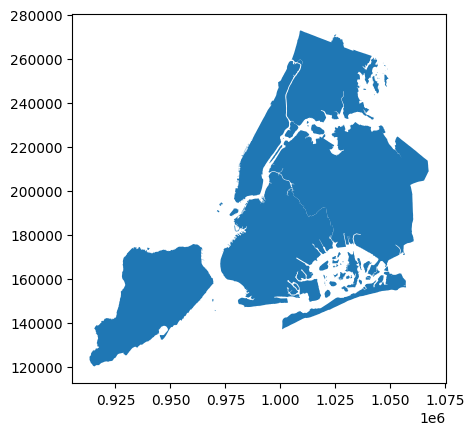

In [33]:
world = gpd.read_file(gpd.datasets.get_path('nybb'))
world.plot()

<AxesSubplot:>

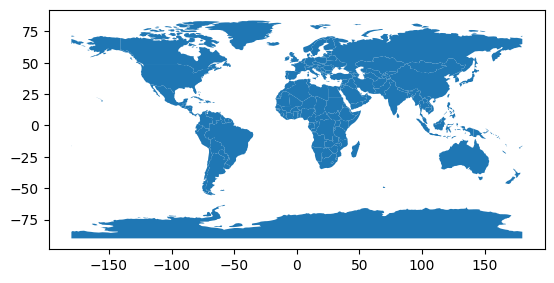

In [35]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

<AxesSubplot:>

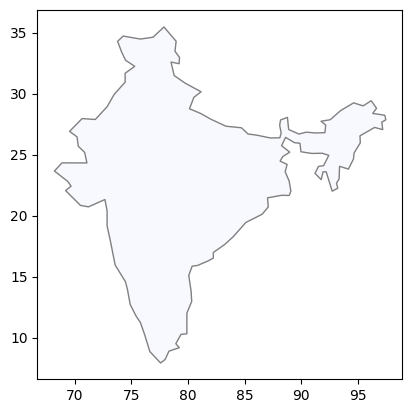

In [22]:
world[world.name == 'India'].plot(edgecolor='gray', color='ghostwhite')

<AxesSubplot:>

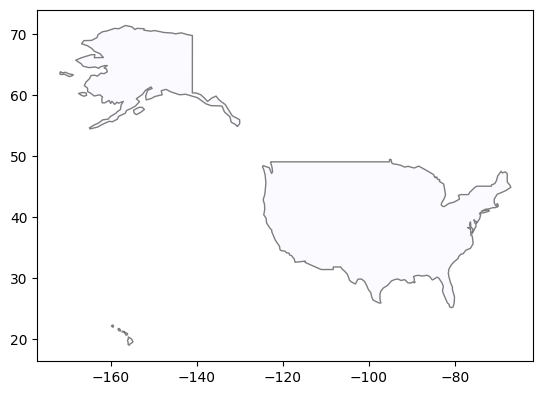

In [36]:
world[world.name == 'United States of America'].plot(edgecolor='black', color='ghostwhite', alpha=0.5)

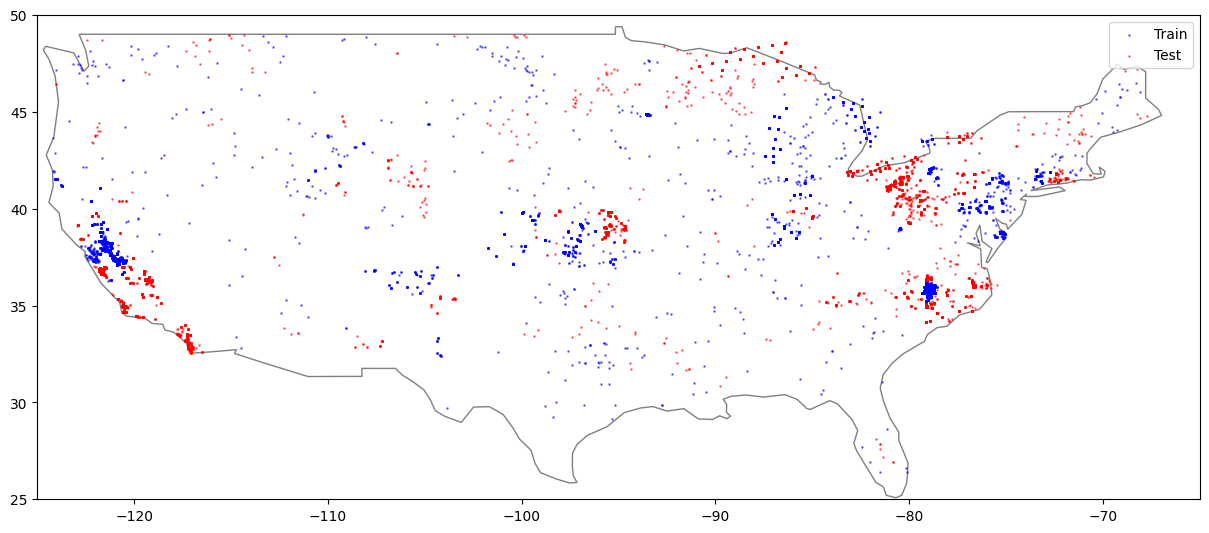

In [42]:
train_meta = metadata[metadata['split'] == 'train']
test_meta = metadata[metadata['split'] == 'test']

base = world[world.name == 'United States of America'].plot(edgecolor='black', color='white', figsize=(15,10), alpha=0.5)

gdf = gpd.GeoDataFrame(train_meta, geometry=gpd.points_from_xy(train_meta.longitude, train_meta.latitude))
gdf.plot(ax=base, marker='.', color='blue', markersize=3, alpha=0.5)

gdf = gpd.GeoDataFrame(test_meta, geometry=gpd.points_from_xy(test_meta.longitude, test_meta.latitude))
gdf.plot(ax=base, marker='.', color='red', markersize=3, alpha=0.5)

plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(['Train', 'Test'])

In [45]:
metadata.date = pd.to_datetime(metadata.date)
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

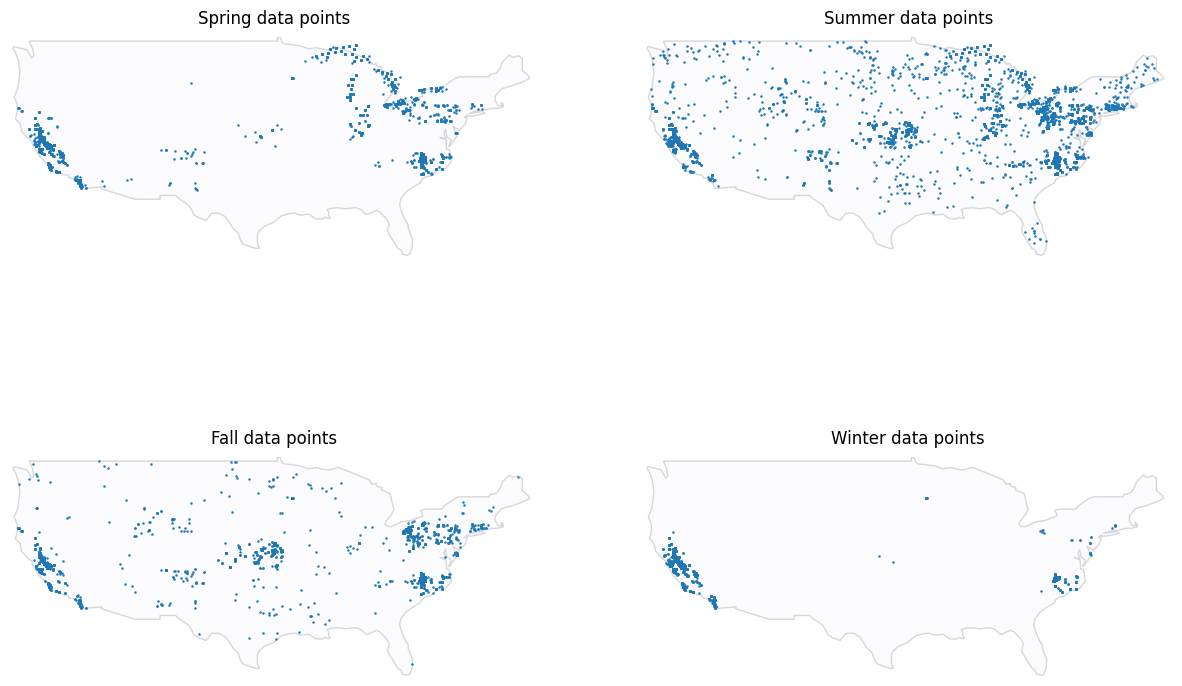

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

<AxesSubplot:>

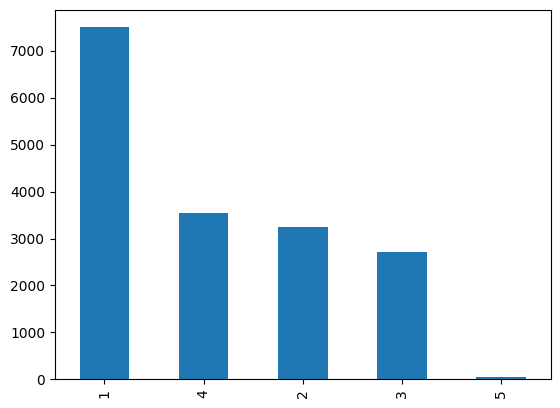

In [49]:
train_labels = pd.read_csv('../data/train_labels.csv')
train_labels.severity.value_counts().plot.bar()